<a href="https://colab.research.google.com/github/gombergere/arthomas/blob/master/Copy_of_Dog_Breed_Dectector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://www.nexmo.com/blog/2018/12/04/dog-breed-detector-using-machine-learning-dr
#Appli très interessante car typique DL
# Apprend comment utiliser les dataset de Keras
# Comment structurer l'arborescene des fichiers
# Comment creer les classes à partir d'un fichier *.csv
# Comment creer son propre réseau neuronal
# Comment préparer les images à evaluer, transformées en "arrays"
# Comment faire la fonction de prédictions
# etc,etc

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#download the dataset for the dog-breed identification challenge https://www.kaggle.com/c/dog-breed-identification
!kaggle competitions download -c dog-breed-identification


In [0]:
#unzip the downloaded files
!unzip labels.csv.zip
!unzip test.zip
!unzip train.zip

In [0]:
#import the neccesary packages
import pandas as pd
import numpy as np

#constants
num_classes = 12 # the number of breeds we want to classify
seed = 42 # makes the random numbers in numpy predictable
im_size = 299 # This size of the images
batch_size = 32

#read the csv into a dataframe, group the breeds and 
df = pd.read_csv('labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)

breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

df.head()

In [0]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    path =  train_or_test + "/" + img_id + ".jpg"
    img = image.load_img(path, target_size=size)
    return image.img_to_array(img)

In [0]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
np.random.seed(seed=seed)
rnd = np.random.random(len(df))
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9
y_train = label_enc.fit_transform(df["breed"].values)
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [0]:
from tqdm import tqdm
from keras.applications import xception

x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    img = read_img(img_id, 'train', (im_size, im_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train, 
                                     ytr, 
                                     batch_size=batch_size)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(x_valid, 
                                     yv, 
                                     batch_size=batch_size)

In [0]:

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer and set it to the number of breeds we want to classifiy, 
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10
learning_rate = 0.001

# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=False,
                                  verbose=1)



# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=learning_rate, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_idx.sum() // batch_size,
                           epochs=epochs, callbacks=[early_stopping, model_checkpoint],
                           validation_data=valid_generator,
                           validation_steps=valid_idx.sum() // batch_size)

# serialize weights to HDF5
model.save(bst_model_path)
print("Saved model to disk")

In [0]:
import matplotlib.pyplot as plt
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def predict_from_image(img_path):

    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    pred = model.predict(img_tensor)
    sorted_breeds_list = sorted(selected_breed_list)
    predicted_class = sorted_breeds_list[np.argmax(pred)]
    
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return predicted_class

In [33]:
!wget http://www.dogbreedslist.info/uploads/allimg/dog-pictures/Scottish-Deerhound-1.jpg
img_path = 'Scottish-Deerhound-1.jpg'    # dog

--2019-11-25 16:27:01--  http://www.dogbreedslist.info/uploads/allimg/dog-pictures/Scottish-Deerhound-1.jpg
Resolving www.dogbreedslist.info (www.dogbreedslist.info)... 66.147.252.246
Connecting to www.dogbreedslist.info (www.dogbreedslist.info)|66.147.252.246|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dogbreedslist.info/uploads/allimg/dog-pictures/Scottish-Deerhound-1.jpg [following]
--2019-11-25 16:27:02--  https://www.dogbreedslist.info/uploads/allimg/dog-pictures/Scottish-Deerhound-1.jpg
Connecting to www.dogbreedslist.info (www.dogbreedslist.info)|66.147.252.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11072 (11K) [image/jpeg]
Saving to: ‘Scottish-Deerhound-1.jpg.2’

Scottish-Deerhound- 100%[===================>]  10.81K  --.-KB/s    in 0s      

2019-11-25 16:27:02 (328 MB/s) - ‘Scottish-Deerhound-1.jpg.2’ saved [11072/11072]



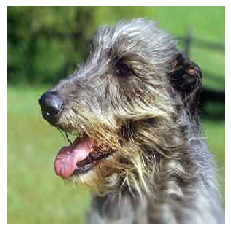

'scottish_deerhound'

In [0]:

predict_from_image(img_path)